In [835]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as scs
import numpy as np
import seaborn as sns
from scipy.spatial.distance import euclidean as euc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from visualize import generate_moons_df, preprocess, plot_boundaries

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

from sklearn.pipeline import Pipeline

from collections import defaultdict
import statistics

In [836]:
bw = pd.read_pickle('bw.pkl')

## First Simple Model

As a first pass with my data, I'm going to create a simple model to get a baseline of the model with two features: **trip duration** and **Manhattan distance**.

In [837]:
bw_plus = pd.read_pickle('bw.pkl')
bw_plus.drop(['access_method'],axis=1,inplace=True)
bw_plus = bw_plus.replace(r'', np.NaN, regex=True)
bw_plus.dropna(axis = 1, inplace=True)
bw_plus.shape

(81389, 20)

In [838]:
bw_plus.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,start_zip,end_zip,start_transit,end_transit,start_city,end_city,is_subscriber,manhattan_dist,start_cap,end_cap
0,840,1/21/20 18:04,1/21/20 18:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
1,613,1/17/20 18:49,1/17/20 19:00,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
2,884,1/14/20 18:07,1/14/20 18:22,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
3,1171,1/29/20 17:12,1/29/20 17:32,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23
4,1401,1/8/20 18:55,1/8/20 19:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23


In [839]:
features = ['duration_sec','manhattan_dist']

X = bw_plus[features]
y = bw_plus['is_subscriber']

In [840]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train)

In [841]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

### KNN

I will use K-Nearest Neighbors to establish a baseline.

In [842]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=10)

In [843]:
y_val_pred = knn.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     10886
           1       0.32      0.02      0.03      2137

    accuracy                           0.83     13023
   macro avg       0.58      0.51      0.47     13023
weighted avg       0.75      0.83      0.76     13023



In [844]:
k_range = list(range(1, 35))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_val_scaled, y_val, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
list(zip(list(range(1, 35)),k_scores))

[(1, 0.7330086071018906),
 (2, 0.8218532088893291),
 (3, 0.7949774418717057),
 (4, 0.825692924162956),
 (5, 0.8164015924494225),
 (6, 0.8303003938683389),
 (7, 0.8223148636079095),
 (8, 0.8318356080084598),
 (9, 0.8272287277498576),
 (10, 0.8322198094200669),
 (11, 0.8296857777101879),
 (12, 0.8339092817826756),
 (13, 0.8335251982604248),
 (14, 0.8351375709841286),
 (15, 0.8340625379456365),
 (16, 0.8352145527336774),
 (17, 0.8348305281561043),
 (18, 0.8352913576491918),
 (19, 0.835444908535543),
 (20, 0.8354449674802211),
 (21, 0.8354450264248993),
 (22, 0.8355218313404137),
 (23, 0.8355986362559283),
 (24, 0.835828992057794),
 (25, 0.8358289920577942),
 (26, 0.8359057380286306),
 (27, 0.8359825429441452),
 (28, 0.8359825429441452),
 (29, 0.8359825429441452),
 (30, 0.8359057380286306),
 (31, 0.8359825429441452),
 (32, 0.8359825429441452),
 (33, 0.8359825429441452),
 (34, 0.8359825429441452)]

In [845]:
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=27)

In [847]:
y_val_pred = knn.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     10886
           1       0.55      0.01      0.02      2137

    accuracy                           0.84     13023
   macro avg       0.69      0.50      0.46     13023
weighted avg       0.79      0.84      0.76     13023



Not very good at all!

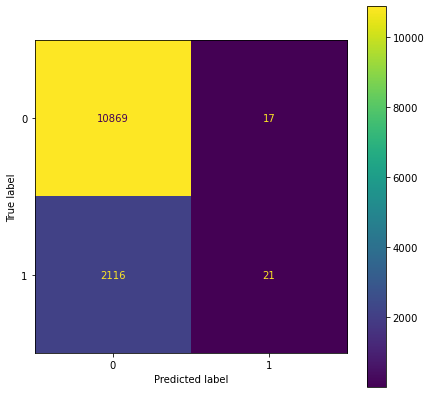

In [848]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_val_scaled, y_val, ax=ax);

ROC AUC score =  0.5739799355055082


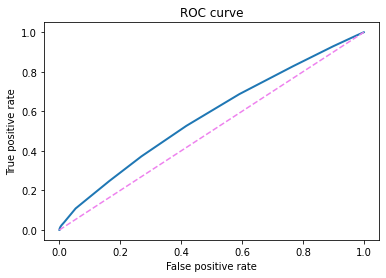

In [849]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))

---

---

# Adding More Features

I'm going to now do some additional preprocessing and one hot encoding so I can add the other features.

In [851]:
bw_plus.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,start_zip,end_zip,start_transit,end_transit,start_city,end_city,is_subscriber,manhattan_dist,start_cap,end_cap
0,840,1/21/20 18:04,1/21/20 18:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
1,613,1/17/20 18:49,1/17/20 19:00,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
2,884,1/14/20 18:07,1/14/20 18:22,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
3,1171,1/29/20 17:12,1/29/20 17:32,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23
4,1401,1/8/20 18:55,1/8/20 19:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23


## Preprocessing and One Hot Encoder

In [852]:
features = ['duration_sec','start_lat','end_lat','start_long', 'end_long', 'manhattan_dist','start_transit','end_transit','start_cap','end_cap','start_city','end_city', 'start_zip','end_zip']

X = bw_plus[features]
y = bw_plus['is_subscriber']

In [853]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train)

In [854]:
#specify categorical features
categoricals = ['start_city','end_city','start_zip','end_zip']
numericals = ['start_lat','end_lat','start_long', 'end_long','duration_sec','manhattan_dist','start_transit','end_transit','start_cap','end_cap']

ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

#train
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values

X_train_preprocessed = pd.concat([X_train.loc[:, numericals], X_train_ohe], axis=1)

#val
cat_matrix_val = ohe.transform(X_val.loc[:, categoricals])

X_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_val.index) #keep the same index values

X_val_preprocessed = pd.concat([X_val.loc[:, numericals], X_val_ohe], axis=1)

#Scale data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed)
X_val_preprocessed = ss.transform(X_val_preprocessed)

In [477]:
type_count = bw_plus.user_type.value_counts()
print(f'Customer: {type_count[0]}')
print(f'Subscriber: {type_count[1]}')
print(f'Proportion: {round(type_count[0] / type_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(type_count[0] / sum(type_count), 4)*100}')

Customer: 68032
Subscriber: 13357
Proportion: 5.09 : 1
Percentage of Majority Class: 83.59


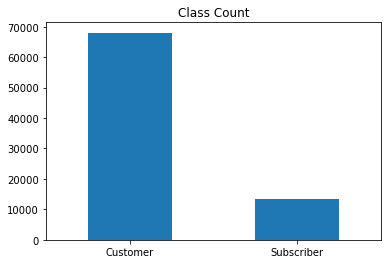

In [478]:
type_count.plot(kind='bar', title='Class Count', rot=0);

## Dealing with Class Imbalance

As you can see in the numbers and bar graph above, there are about 5 times as many people in the customer class as the subscriber class.

We can fix that by trying a few methods: Random Oversampler, SMOTE, and ADASYN.

### Random Oversampler

In [479]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train_ROS, y_train_ROS = ros.fit_sample(X_train_preprocessed,y_train)
X_val_ROS, y_val_ROS = ros.fit_sample(X_val_preprocessed,y_val)
#X_test_resampled, y_test_resampled = ros.fit_sample(X_test_preprocessed,y_test)

In [480]:
from collections import Counter

Counter(y_train_ROS)

Counter({0: 38097, 1: 38097})

Hooray! Now they're even.

#### KNN

I'm going to use cross validation to find the best k.

In [481]:
k_range = list(range(1, 30))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_val_preprocessed, y_val, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
list(zip(list(range(1, 30)),k_scores))

[(1, 0.7694605147636431),
 (2, 0.8247463918796113),
 (3, 0.7994737612248357),
 (4, 0.8272054587742403),
 (5, 0.8141288141336659),
 (6, 0.8278192628190318),
 (7, 0.8229052107881645),
 (8, 0.8286088905318607),
 (9, 0.8243972090014324),
 (10, 0.8306267424487469),
 (11, 0.8299254501486377),
 (12, 0.8332599386966099),
 (13, 0.8315926559154689),
 (14, 0.8340496434237483),
 (15, 0.8337866395576299),
 (16, 0.8342253900774764),
 (17, 0.833962309197049),
 (18, 0.8348396562081234),
 (19, 0.8336988432450749),
 (20, 0.8344884709579039),
 (21, 0.8333477350091648),
 (22, 0.835102968131479),
 (23, 0.8351029681314788),
 (24, 0.8349279146065338),
 (25, 0.8343133404186499),
 (26, 0.8349277605779154),
 (27, 0.834313417432959),
 (28, 0.8349277605779154),
 (29, 0.834488779015141)]

22 it is.

In [482]:
knn = KNeighborsClassifier(n_neighbors=22)

In [483]:
knn.fit(X_train_ROS, y_train_ROS)

y_pred = knn.predict(X_val_preprocessed)

print("Training set: ", knn.score(X_train_ROS, y_train_ROS))
print("Val set: ", knn.score(X_val_preprocessed, y_val))
print(classification_report(y_val, y_pred, zero_division=1))

Training set:  0.7313961729270021
Val set:  0.6587099605089952
              precision    recall  f1-score   support

           0       0.89      0.67      0.77      9525
           1       0.26      0.58      0.36      1870

    accuracy                           0.66     11395
   macro avg       0.57      0.63      0.56     11395
weighted avg       0.79      0.66      0.70     11395



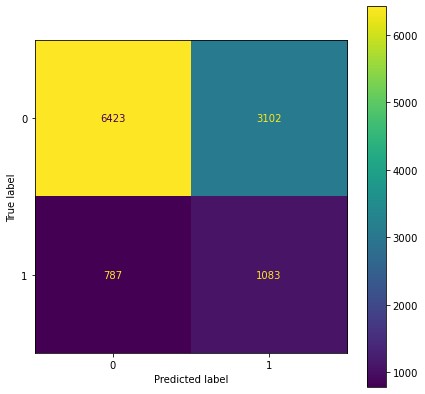

In [484]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_val_preprocessed, y_val, ax=ax);

In [485]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_preprocessed)[:,1])

ROC AUC score =  0.6771898606257106


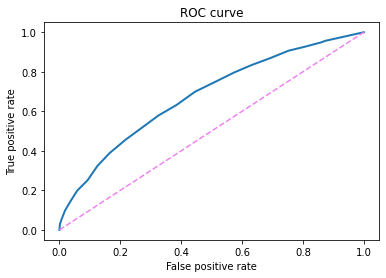

In [486]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_preprocessed)[:,1]))

A much better result using more features!

Now let's try logistic regression.

#### Logistic Regression

In [386]:
lr = LogisticRegression(penalty='none',class_weight='balanced',max_iter=2000)
lr.fit(X_train_ROS, y_train_ROS)

y_pred = lr.predict(X_val_preprocessed)

print("Training set: ", lr.score(X_train_ROS, y_train_ROS))
print("Val set: ", lr.score(X_val_preprocessed, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.6154552851930598
Val set:  0.5341816586222027
              precision    recall  f1-score   support

           0       0.90      0.50      0.64      9525
           1       0.22      0.72      0.34      1870

    accuracy                           0.53     11395
   macro avg       0.56      0.61      0.49     11395
weighted avg       0.79      0.53      0.59     11395



In [387]:
list(zip(lr.coef_[0], X.columns))

[(-0.10413839747415786, 'duration_sec'),
 (-0.3908085643130086, 'start_lat'),
 (0.3496604394408063, 'end_lat'),
 (1.0761809507177205, 'start_long'),
 (-0.31611935436463495, 'end_long'),
 (0.22016455670941573, 'manhattan_dist'),
 (0.02238727133253689, 'start_transit'),
 (-0.036153003754487434, 'end_transit'),
 (0.038046752695933196, 'start_cap'),
 (0.01654692796612429, 'end_cap'),
 (-0.028585943600705797, 'start_city'),
 (0.18466191229588563, 'end_city'),
 (0.11878753733946575, 'start_zip'),
 (-0.10559645225517644, 'end_zip')]

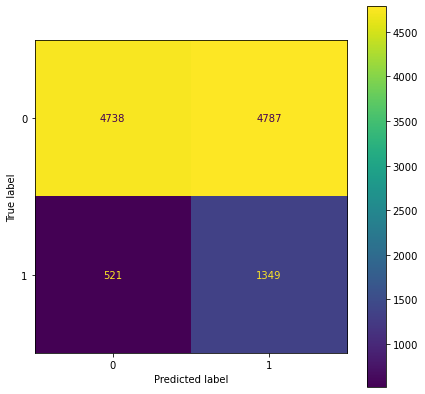

In [388]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_preprocessed, y_val, ax=ax);

ROC AUC score =  0.6565336084326358


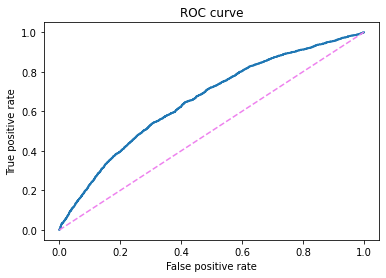

In [389]:
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val_preprocessed)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(X_val_preprocessed)[:,1]))

Pretty good, but a slightly better ROC AUC score using KNN. KNN also has a better recall for the customer (0) variable, which is what I'm focused on for my project, since I'm trying to turn casual customers into subscribers.

## SMOTE

Now let's trying a different oversampling method, SMOTE.

#### KNN

In [390]:
X_smote, y_smote = SMOTE(random_state=42).fit_sample(X_train_preprocessed, y_train)
X_smoted_val, y_smoted_val = SMOTE(random_state=42).fit_sample(X_val_preprocessed, y_val)

knn.fit(X_smote, y_smote)
y_pred = knn.predict(X_val_preprocessed)
print("Training set: ", knn.score(X_smote, y_smote))
print("Val set: ", knn.score(X_val_preprocessed, y_val))
print(classification_report(y_val, y_pred, zero_division=1))

Training set:  0.7376958815654776
Val set:  0.6346643264589732
              precision    recall  f1-score   support

           0       0.89      0.64      0.75      9525
           1       0.25      0.59      0.35      1870

    accuracy                           0.63     11395
   macro avg       0.57      0.62      0.55     11395
weighted avg       0.78      0.63      0.68     11395



ROC AUC score =  0.6683946832849103


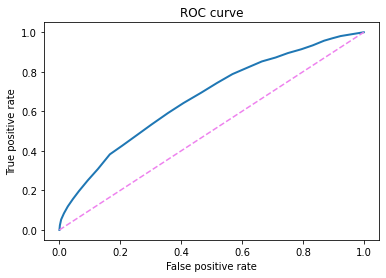

In [391]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_preprocessed)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_preprocessed)[:,1]))

#### Logistic Regression

In [392]:
lr = LogisticRegression(penalty='none',class_weight='balanced',max_iter=2000)
lr.fit(X_smote, y_smote)
y_pred = lr.predict(X_val_preprocessed)
print("Training set: ", lr.score(X_smote, y_smote))
print("Val set: ",lr.score(X_val_preprocessed, y_val))
print(classification_report(y_val, y_pred, zero_division=1))

Training set:  0.6231855526681891
Val set:  0.5516454585344449
              precision    recall  f1-score   support

           0       0.90      0.52      0.66      9525
           1       0.23      0.71      0.34      1870

    accuracy                           0.55     11395
   macro avg       0.56      0.62      0.50     11395
weighted avg       0.79      0.55      0.61     11395



ROC AUC score =  0.6624663775316856


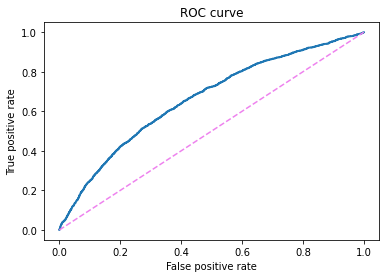

In [393]:
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val_preprocessed)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(X_val_preprocessed)[:,1]))

About the same, and still not as good of recall as using Oversampler with KNN.

### ADASYN

In [394]:
X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train_preprocessed, y_train)
X_adasyn_val, y_adasyn_val = ADASYN(random_state=42).fit_sample(X_val_preprocessed, y_val)

In [395]:
knn.fit(X_adasyn_train, y_adasyn_train)

y_pred = knn.predict(X_val_preprocessed)
print("Training set: ", knn.score(X_adasyn_train, y_adasyn_train))
print("Val set: ", knn.score(X_val_preprocessed, y_val))
print(classification_report(y_val, y_pred, zero_division=1))

Training set:  0.7211422494845093
Val set:  0.5986836331724441
              precision    recall  f1-score   support

           0       0.90      0.59      0.71      9525
           1       0.24      0.66      0.35      1870

    accuracy                           0.60     11395
   macro avg       0.57      0.62      0.53     11395
weighted avg       0.79      0.60      0.65     11395



ROC AUC score =  0.6706446025797577


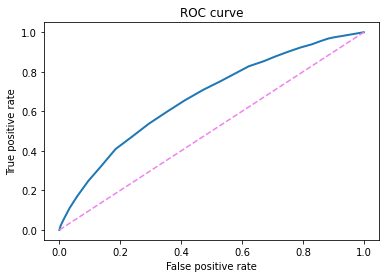

In [396]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_preprocessed)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_preprocessed)[:,1]))

In [397]:
lr.fit(X_adasyn_train, y_adasyn_train)

y_pred = lr.predict(X_val_preprocessed)
print("Training set: ", lr.score(X_adasyn_train, y_adasyn_train))
print("Val set: ", lr.score(X_val_preprocessed, y_val))
print(classification_report(y_val, y_pred, zero_division=1))

Training set:  0.6109374797370025
Val set:  0.5102237823606846
              precision    recall  f1-score   support

           0       0.91      0.46      0.61      9525
           1       0.22      0.76      0.34      1870

    accuracy                           0.51     11395
   macro avg       0.56      0.61      0.47     11395
weighted avg       0.79      0.51      0.57     11395



In [398]:
print(precision_score(y_val, y_pred, average='weighted', zero_division='warn'))

0.7935026030733786


ROC AUC score =  0.6659324041714036


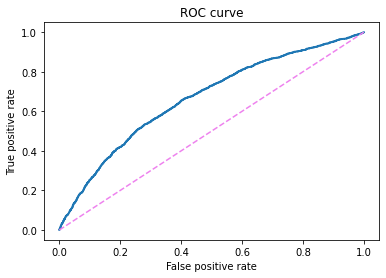

In [399]:
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val_preprocessed)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(X_val_preprocessed)[:,1]))

No noticeable improvement using KNN and Logistic Regression with ADASYN either.

---

# Model Selection Pipeline

Now that I've tried out a few oversampling techniques, I'm going to create a a model selection pipeline so I can try out a few different models at once.

First, I'm going to calculate weighted average metrics through cross validation.

In [858]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [859]:
#specify categorical features
categoricals = ['start_city','end_city','start_zip','end_zip']
numericals = ['start_lat','end_lat','start_long', 'end_long','duration_sec','manhattan_dist','start_transit','end_transit','start_cap','end_cap']

models = {"KNN": KNeighborsClassifier(n_neighbors=10),
          "Logistic Reg": LogisticRegression(penalty='none',class_weight='balanced',max_iter=2000),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "BernoulliNB": BernoulliNB(),
          "GaussianNB": GaussianNB(),
          "XGBoost": XGBClassifier()
         }

In [860]:
def get_metrics_ROS(models):

    for model_name, model in models.items():

        kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        kf.get_n_splits(X_train_val, y_train_val)

        train_scores= []
        val_scores= []
        cv_accuracy = []
        cv_precision = []
        cv_recall = []
        cv_f1 = []
        cv_AUC = []

        for train, val in kf.split(X_train_val, y_train_val):

            #Set up train and val for each fold
            X_train, X_val = X_train_val.iloc[train], X_train_val.iloc[val]
            y_train, y_val = y_train_val.iloc[train], y_train_val.iloc[val]

            #OneHotEncode categorical variables
            ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

            cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

            X_train_ohe = pd.DataFrame(cat_matrix_train,
                               columns=ohe.get_feature_names(categoricals), #create meaningful column names
                               index=X_train.index) #keep the same index values
            X_train_preprocessed = pd.concat([X_train.loc[:, numericals], X_train_ohe], axis=1)

            #val
            cat_matrix_val = ohe.transform(X_val.loc[:, categoricals])

            X_val_ohe = pd.DataFrame(cat_matrix_val,
                               columns=ohe.get_feature_names(categoricals), #create meaningful column names
                               index=X_val.index) #keep the same index values
            X_val_preprocessed = pd.concat([X_val.loc[:, numericals], X_val_ohe], axis=1)

            #Scale data
            ss = StandardScaler()

            #fit transform X train
            X_train_scaled = ss.fit_transform(X_train_preprocessed)
            #transform X val
            X_val_scaled = ss.transform(X_val_preprocessed)

            #Oversample train data
            X_train_ROS, y_train_ROS = ros.fit_sample(X_train_scaled, y_train)

            #fit model
            model.fit(X_train_ROS, y_train_ROS)

            #make prediction using y-val
            y_pred = model.predict(X_val_scaled)

            #metrics
            train_scores.append(model.score(X_train_ROS, y_train_ROS))
            val_scores.append(model.score(X_val_scaled, y_val))

            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred)
            recall = recall_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            AUC = roc_auc_score(y_val, y_pred)

            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_AUC.append(AUC)

        mean_train = np.mean(train_scores)
        mean_val = np.mean(val_scores)

        cv_accuracy = "Accuracy: {}, Variance: {}".format(statistics.mean(cv_accuracy), statistics.variance(cv_accuracy))
        cv_precision = "Precision: {}, Variance: {}".format(statistics.mean(cv_precision), statistics.variance(cv_precision))
        cv_recall = "Recall: {}, Variance: {}".format(statistics.mean(cv_recall), statistics.variance(cv_recall))
        cv_f1 = "F1 Score: {}, Variance: {}".format(statistics.mean(cv_f1), statistics.variance(cv_f1))
        cv_AUC = "AUC Score: {}, Variance: {}".format(statistics.mean(cv_AUC), statistics.variance(cv_AUC))

        print(model_name, ":")
        print(f'Train/Test ratio: {(mean_train)/(mean_val):.4f}')
        print(cv_accuracy)
        print(cv_precision)
        print(cv_recall)
        print(cv_f1)
        print(cv_AUC)
        print('\n')

In [861]:
models = {"KNN": KNeighborsClassifier(n_neighbors=10),
          "Logistic Reg": LogisticRegression(penalty='none',class_weight='balanced',max_iter=2000),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "BernoulliNB": BernoulliNB(),
          "GaussianNB": GaussianNB(),
          "XGBoost": XGBClassifier()
         }

get_metrics_ROS(models)

KNN :
Train/Test ratio: 1.1912
Accuracy: 0.6768412525995569, Variance: 2.4005976842347437e-05
Precision: 0.26316654295929787, Variance: 4.848927091712662e-05
Recall: 0.5385026737967915, Variance: 0.00034073036117704197
F1 Score: 0.3535333232014046, Variance: 9.856153321483746e-05
AUC Score: 0.6212524425455741, Variance: 8.348648178320196e-05


Logistic Reg :
Train/Test ratio: 1.1430
Accuracy: 0.5352978723781167, Variance: 3.891756262414203e-05
Precision: 0.22016478269377343, Variance: 8.84719865631221e-06
Recall: 0.7205347593582887, Variance: 0.0003209414052446463
F1 Score: 0.3372553190812099, Variance: 2.4934750017221935e-05
AUC Score: 0.609731721730886, Variance: 4.2007894373774686e-05


Decision Tree :
Train/Test ratio: 1.2806
Accuracy: 0.7781190657685088, Variance: 1.9503938210489085e-05
Precision: 0.32103399002899125, Variance: 0.00012726242215165714
Recall: 0.31540106951871655, Variance: 8.112899997140313e-05
F1 Score: 0.31816628395354246, Variance: 9.289108962658949e-05
AUC Scor

### Further Narrowing

Now I'm going to do classification reports for the top performing models by AUC-ROC score: KNN, Random Forest, and XGBoost. The latter two are already tree models, so no need to also use Decision Tree. I'll try the three oversampling techniques (ROS, SMOTE, and ADASYN) for each.

In [449]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [450]:
categoricals = ['start_city','end_city','start_zip','end_zip']
numericals = ['start_lat','end_lat','start_long', 'end_long','duration_sec','manhattan_dist','start_transit','end_transit','start_cap','end_cap']

In [451]:
new_models = {"KNN": KNeighborsClassifier(n_neighbors=10), "Random Forest": RandomForestClassifier(),"XGBoost": XGBClassifier()}

#### Random Over Sampler

In [452]:
for model_name, model in new_models.items():
    
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    kf.get_n_splits(X_train_val, y_train_val)
    
    for train, val in kf.split(X_train_val, y_train_val):
        
        #Set up train and val for each fold
        X_train, X_val = X_train_val.iloc[train], X_train_val.iloc[val]
        y_train, y_val = y_train_val.iloc[train], y_train_val.iloc[val]
        
        #OneHotEncode categorical variables
        ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

        cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

        X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values
        X_train_preprocessed = pd.concat([X_train.loc[:, numericals], X_train_ohe], axis=1)

        #val
        cat_matrix_val = ohe.transform(X_val.loc[:, categoricals])

        X_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_val.index) #keep the same index values
        X_val_preprocessed = pd.concat([X_val.loc[:, numericals], X_val_ohe], axis=1)
        
        #Scale data
        ss = StandardScaler()
        
        #fit transform X train
        X_train_scaled = ss.fit_transform(X_train_preprocessed)
        #transform X val
        X_val_scaled = ss.transform(X_val_preprocessed)
        
        #Oversample train data
        X_train_ROS, y_train_ROS = ros.fit_sample(X_train_scaled, y_train)

        #fit model
        model.fit(X_train_ROS, y_train_ROS)
        
        #make prediction using y-val
        y_pred = model.predict(X_val_scaled)

    #metrics
    print(model_name, classification_report(y_val, y_pred))

KNN               precision    recall  f1-score   support

           0       0.89      0.71      0.79      9524
           1       0.27      0.55      0.36      1870

    accuracy                           0.68     11394
   macro avg       0.58      0.63      0.57     11394
weighted avg       0.79      0.68      0.72     11394

Random Forest               precision    recall  f1-score   support

           0       0.87      0.89      0.88      9524
           1       0.35      0.30      0.33      1870

    accuracy                           0.79     11394
   macro avg       0.61      0.60      0.60     11394
weighted avg       0.78      0.79      0.79     11394

XGBoost               precision    recall  f1-score   support

           0       0.90      0.72      0.80      9524
           1       0.29      0.58      0.39      1870

    accuracy                           0.70     11394
   macro avg       0.59      0.65      0.59     11394
weighted avg       0.80      0.70      0.73     

#### SMOTE

In [453]:
for model_name, model in new_models.items():
    
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    kf.get_n_splits(X_train_val, y_train_val)
    
    for train, val in kf.split(X_train_val, y_train_val):
        
        #Set up train and val for each fold
        X_train, X_val = X_train_val.iloc[train], X_train_val.iloc[val]
        y_train, y_val = y_train_val.iloc[train], y_train_val.iloc[val]
        
        #OneHotEncode categorical variables
        ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

        cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

        X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values
        X_train_preprocessed = pd.concat([X_train.loc[:, numericals], X_train_ohe], axis=1)

        #val
        cat_matrix_val = ohe.transform(X_val.loc[:, categoricals])

        X_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_val.index) #keep the same index values
        X_val_preprocessed = pd.concat([X_val.loc[:, numericals], X_val_ohe], axis=1)
        
        #Scale data
        ss = StandardScaler()
        
        #fit transform X train
        X_train_scaled = ss.fit_transform(X_train_preprocessed)
        #transform X val
        X_val_scaled = ss.transform(X_val_preprocessed)
        
        #Oversample train data
        X_train_SMOTE, y_train_SMOTE = SMOTE(random_state=42).fit_sample(X_train_scaled, y_train)

        #fit model
        model.fit(X_train_SMOTE, y_train_SMOTE)
        
        #make prediction using y-val
        y_pred = model.predict(X_val_scaled)

    #metrics
    print(model_name, classification_report(y_val, y_pred))

KNN               precision    recall  f1-score   support

           0       0.88      0.75      0.81      9524
           1       0.28      0.50      0.36      1870

    accuracy                           0.71     11394
   macro avg       0.58      0.62      0.59     11394
weighted avg       0.79      0.71      0.74     11394

Random Forest               precision    recall  f1-score   support

           0       0.87      0.86      0.86      9524
           1       0.33      0.36      0.34      1870

    accuracy                           0.77     11394
   macro avg       0.60      0.61      0.60     11394
weighted avg       0.78      0.77      0.78     11394

XGBoost               precision    recall  f1-score   support

           0       0.88      0.87      0.88      9524
           1       0.38      0.40      0.39      1870

    accuracy                           0.79     11394
   macro avg       0.63      0.63      0.63     11394
weighted avg       0.80      0.79      0.80     

#### ADASYN

In [454]:
for model_name, model in new_models.items():
    
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    kf.get_n_splits(X_train_val, y_train_val)
    
    for train, val in kf.split(X_train_val, y_train_val):
        
        #Set up train and val for each fold
        X_train, X_val = X_train_val.iloc[train], X_train_val.iloc[val]
        y_train, y_val = y_train_val.iloc[train], y_train_val.iloc[val]
        
        #OneHotEncode categorical variables
        ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

        cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

        X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values
        X_train_preprocessed = pd.concat([X_train.loc[:, numericals], X_train_ohe], axis=1)

        #val
        cat_matrix_val = ohe.transform(X_val.loc[:, categoricals])

        X_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_val.index) #keep the same index values
        X_val_preprocessed = pd.concat([X_val.loc[:, numericals], X_val_ohe], axis=1)
        
        #Scale data
        ss = StandardScaler()
        
        #fit transform X train
        X_train_scaled = ss.fit_transform(X_train_preprocessed)
        #transform X val
        X_val_scaled = ss.transform(X_val_preprocessed)
        
        #Oversample train data
        X_train_ADASYN, y_train_ADASYN = ADASYN(random_state=42).fit_sample(X_train_scaled, y_train)

        #fit model
        model.fit(X_train_ADASYN, y_train_ADASYN)
        
        #make prediction using y-val
        y_pred = model.predict(X_val_scaled)

    #metrics
    print(model_name, classification_report(y_val, y_pred))

KNN               precision    recall  f1-score   support

           0       0.89      0.72      0.79      9524
           1       0.27      0.55      0.37      1870

    accuracy                           0.69     11394
   macro avg       0.58      0.63      0.58     11394
weighted avg       0.79      0.69      0.72     11394

Random Forest               precision    recall  f1-score   support

           0       0.87      0.85      0.86      9524
           1       0.32      0.36      0.34      1870

    accuracy                           0.77     11394
   macro avg       0.59      0.61      0.60     11394
weighted avg       0.78      0.77      0.77     11394

XGBoost               precision    recall  f1-score   support

           0       0.88      0.87      0.87      9524
           1       0.36      0.38      0.37      1870

    accuracy                           0.79     11394
   macro avg       0.62      0.62      0.62     11394
weighted avg       0.79      0.79      0.79     

# Model Optimization

After looking at the classification reports, I'm going to remove Random Forest from the choice of optimal models. While the precision tends to be slightly higher than KNN, the recall is not good at all. Recall is more important for my purposes, so I'm going to further examine KNN and XGBoost. RandomSampler has the best recall, so I'm going to disregard SMOTE and ADASYN.

In [862]:
newer_models = {"KNN": KNeighborsClassifier(n_neighbors=22),
                "XGBoost default": XGBClassifier(),
                "XGBoost depth 4": XGBClassifier(n_estimators=100, max_depth=4,learning_rate=.05, subsample=.8,
                                                 min_child_weight=3, colsample_bytree=.8),
                "XGBoost depth 5": XGBClassifier(n_estimators=100, max_depth=5,learning_rate=.05, subsample=.8,
                                                 min_child_weight=3, colsample_bytree=.8),
                "XGBoost depth 6": XGBClassifier(n_estimators=100, max_depth=6,learning_rate=.05, subsample=.8,
                                                 min_child_weight=3, colsample_bytree=.8),
                "XGBoost depth 7": XGBClassifier(max_depth = 7),
                "XGBoost depth 7, learning rate 0.5": XGBClassifier(max_depth = 7, learning_rate=.05)}

In [509]:
for model_name, model in newer_models.items():
    
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    kf.get_n_splits(X_train_val, y_train_val)
    
    for train, val in kf.split(X_train_val, y_train_val):
        
        #Set up train and val for each fold
        X_train, X_val = X_train_val.iloc[train], X_train_val.iloc[val]
        y_train, y_val = y_train_val.iloc[train], y_train_val.iloc[val]
        
        #OneHotEncode categorical variables
        ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

        cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

        X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values
        X_train_preprocessed = pd.concat([X_train.loc[:, numericals], X_train_ohe], axis=1)

        #val
        cat_matrix_val = ohe.transform(X_val.loc[:, categoricals])

        X_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_val.index) #keep the same index values
        X_val_preprocessed = pd.concat([X_val.loc[:, numericals], X_val_ohe], axis=1)
        
        #Scale data
        ss = StandardScaler()
        
        #fit transform X train
        X_train_scaled = ss.fit_transform(X_train_preprocessed)
        #transform X val
        X_val_scaled = ss.transform(X_val_preprocessed)
        
        #Oversample train data
        X_train_ROS, y_train_ROS = ros.fit_sample(X_train_scaled, y_train)

        #fit model
        model.fit(X_train_ROS, y_train_ROS)
        
        #make prediction using y-val
        y_pred = model.predict(X_val_scaled)

    #metrics
    print(model_name, classification_report(y_val, y_pred))
    print(model_name, "ROC AUC score: ", roc_auc_score(y_val, y_pred))

KNN               precision    recall  f1-score   support

           0       0.89      0.67      0.76      9524
           1       0.26      0.58      0.36      1870

    accuracy                           0.66     11394
   macro avg       0.57      0.63      0.56     11394
weighted avg       0.79      0.66      0.70     11394

KNN ROC AUC score:  0.625102751955656
XGBoost default               precision    recall  f1-score   support

           0       0.90      0.72      0.80      9524
           1       0.29      0.58      0.39      1870

    accuracy                           0.70     11394
   macro avg       0.59      0.65      0.59     11394
weighted avg       0.80      0.70      0.73     11394

XGBoost default ROC AUC score:  0.6525365134408542
XGBoost depth 4               precision    recall  f1-score   support

           0       0.91      0.56      0.70      9524
           1       0.24      0.70      0.36      1870

    accuracy                           0.59     11394
   

# Final Model

### XGBClassifier(max_depth = 7)

I've tried out a bunch of XGBoost parameters (the above is just a subsample), but it looks like `XGBClassifier(max_depth = 7)` is the best for the AUC score, and the recall is the highest (0.77) for the casual user classifier. Since I'm trying to grab existing casual users and convert them to subscribers, this is a good option.

In [864]:
features = ['duration_sec','start_lat','end_lat','start_long', 'end_long', 'manhattan_dist','start_transit','end_transit','start_cap','end_cap','start_city','end_city', 'start_zip','end_zip']

X = bw_plus[features]
y = bw_plus['is_subscriber']

In [865]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [866]:
categoricals = ['start_city','end_city','start_zip','end_zip']
numericals = ['start_lat','end_lat','start_long', 'end_long','duration_sec','manhattan_dist','start_transit','end_transit','start_cap','end_cap']

In [867]:
final_model = XGBClassifier(max_depth = 7)
    
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
kf.get_n_splits(X, y)
    
for train, test in kf.split(X, y):
        
    #Set up train and val for each fold
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
        
    #OneHotEncode categorical variables
    ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

    cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

    X_train_ohe = pd.DataFrame(cat_matrix_train,
                       columns=ohe.get_feature_names(categoricals), #create meaningful column names
                       index=X_train.index) #keep the same index values
    X_train_preprocessed = pd.concat([X_train.loc[:, numericals], X_train_ohe], axis=1)

    #val
    cat_matrix_test = ohe.transform(X_test.loc[:, categoricals])

    X_test_ohe = pd.DataFrame(cat_matrix_test,
                       columns=ohe.get_feature_names(categoricals), #create meaningful column names
                       index=X_test.index) #keep the same index values
    X_test_preprocessed = pd.concat([X_test.loc[:, numericals], X_test_ohe], axis=1)

    #Scale data
    ss = StandardScaler()

    #fit transform X train
    X_train_scaled = ss.fit_transform(X_train_preprocessed)
    #transform X val
    X_test_scaled = ss.transform(X_test_preprocessed)
    X_test_scaled_pd = pd.DataFrame(X_test_scaled, columns=X_test_preprocessed.columns)

    #Oversample train data
    X_train_ROS, y_train_ROS = ros.fit_sample(X_train_scaled, y_train)

    X_train_ROS_pd = pd.DataFrame(X_train_ROS, columns=X_train_preprocessed.columns)
    #fit model
    final_model.fit(X_train_ROS_pd, y_train_ROS)

    #make prediction using y-val
    y_pred = final_model.predict(X_test_scaled_pd)

#metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83     13606
           1       0.32      0.57      0.41      2671

    accuracy                           0.73     16277
   macro avg       0.61      0.66      0.62     16277
weighted avg       0.80      0.73      0.76     16277



The test data has a similar recall for the 0 class, 0.76.

ROC AUC score =  0.7248155462278986


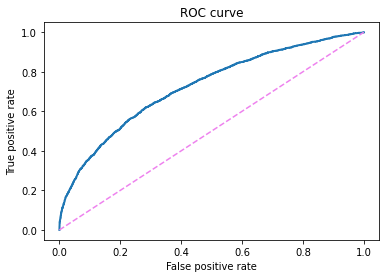

In [868]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test_scaled_pd)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, final_model.predict_proba(X_test_scaled_pd)[:,1]))

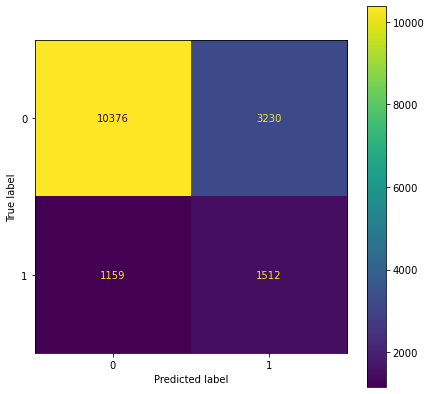

In [869]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(final_model, X_test_scaled_pd, y_test, ax=ax, values_format = '.0f');

# A little feature engineering...

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

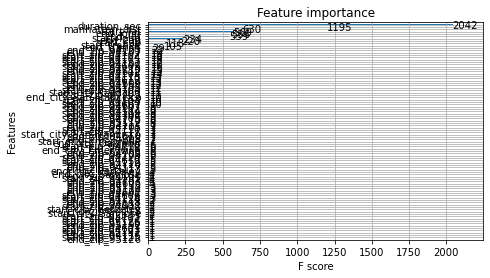

In [871]:
xgb.plot_importance(final_model)

It's hard to see in this very scrunched up graph, but all of those features with little feature importance are the city and zip data. I'm going to try without them, so no need to One Hot Encode!

In [879]:
features = ['duration_sec','start_lat','end_lat','start_long', 'end_long', 'manhattan_dist','start_transit','end_transit','start_cap','end_cap']

X = bw_plus[features]
y = bw_plus['is_subscriber']

In [880]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [881]:
final_model = XGBClassifier(max_depth = 7)
    
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
kf.get_n_splits(X, y)
    
for train, test in kf.split(X, y):
        
    #Set up train and val for each fold
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    #Scale data
    ss = StandardScaler()

    #fit transform X train
    X_train_scaled = ss.fit_transform(X_train)
    #transform X val
    X_test_scaled = ss.transform(X_test)
    X_test_scaled_pd = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    #Oversample train data
    X_train_ROS, y_train_ROS = ros.fit_sample(X_train_scaled, y_train)

    X_train_ROS_pd = pd.DataFrame(X_train_ROS, columns=X_train.columns)
    #fit model
    final_model.fit(X_train_ROS_pd, y_train_ROS)

    #make prediction using y-val
    y_pred = final_model.predict(X_test_scaled_pd)

#metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83     13606
           1       0.32      0.56      0.41      2671

    accuracy                           0.73     16277
   macro avg       0.61      0.66      0.62     16277
weighted avg       0.80      0.73      0.76     16277



ROC AUC score =  0.7244331059925608


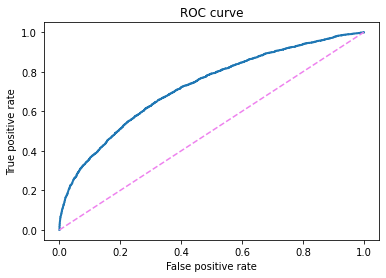

In [882]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test_scaled_pd)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, final_model.predict_proba(X_test_scaled_pd)[:,1]))

Almost the exact same result (in fact, a .01 increase in recall for the casual customer class), but with way fewer features! I also tried playing around with more feature removal but didn't get any better results.

Let's go with this version of the model.

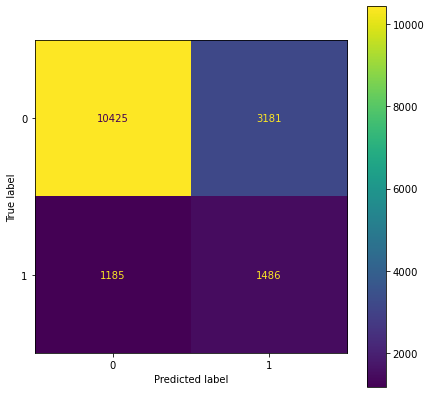

In [883]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(final_model, X_test_scaled_pd, y_test, ax=ax, values_format = '.0f');

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

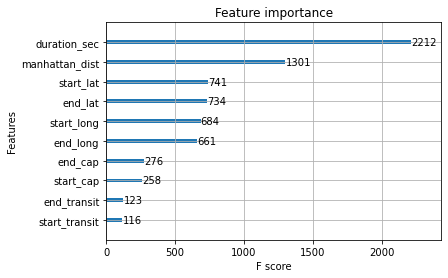

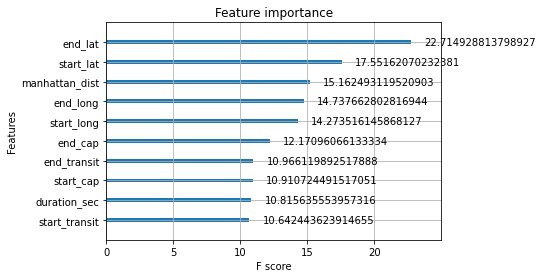

In [885]:
xgb.plot_importance(final_model)
xgb.plot_importance(final_model, importance_type='gain')

# Wrap-Up

### Retraining on All Data

In [886]:
X_oversampled, y_oversampled = RandomOverSampler(random_state=42).fit_sample(X, y)

X_oversampled_pd = pd.DataFrame(X_oversampled, columns=X.columns)

final_model.fit(X_oversampled_pd, y_oversampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Preparing Model for Predicting New Data

In [887]:
bw_plus.head(5)

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,start_zip,end_zip,start_transit,end_transit,start_city,end_city,is_subscriber,manhattan_dist,start_cap,end_cap
0,840,1/21/20 18:04,1/21/20 18:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
1,613,1/17/20 18:49,1/17/20 19:00,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
2,884,1/14/20 18:07,1/14/20 18:22,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
3,1171,1/29/20 17:12,1/29/20 17:32,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23
4,1401,1/8/20 18:55,1/8/20 19:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23


In [888]:
bw_final = bw_plus.drop(['start_time','end_time','start_zip','end_zip','start_city','end_city','user_type','is_subscriber'],axis=1)

In [890]:
bw_final.head(5)

,duration_sec,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,start_transit,end_transit,manhattan_dist,start_cap,end_cap
0,840,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,2,1,0.033857,35,23
1,613,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,2,1,0.033857,35,23
2,884,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,2,1,0.033857,35,23
3,1171,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,2,1,0.035492,35,23
4,1401,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,2,1,0.035492,35,23


In [891]:
final_model.feature_names = X_oversampled_pd.columns
final_model.feature_names

Index(['duration_sec', 'start_lat', 'end_lat', 'start_long', 'end_long',
       'manhattan_dist', 'start_transit', 'end_transit', 'start_cap',
       'end_cap'],
      dtype='object')

In [892]:
final_model.target_names = bw_plus['user_type'].unique()
final_model.target_names

array(['Subscriber', 'Customer'], dtype=object)

In [893]:
test_input = np.random.rand(1,10)
test_input_pd = pd.DataFrame(test_input, columns=X.columns)

final_model.predict(test_input_pd)

array([1])

In [894]:
test_input = np.array([[100, 37.773507, -122.416040, 37.770030, -122.411726, 1, 1, 0.007792, 19, 27]])

In [895]:
test_input_pd = pd.DataFrame(test_input, columns=X.columns)

In [896]:
final_model.predict(test_input_pd)

array([1])